In [31]:
import numpy as np
import pandas as pd

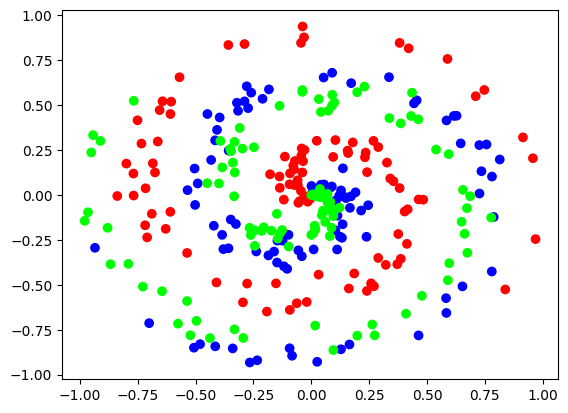

In [32]:
#main dataset

from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt
import numpy as np 
import nnfs
nnfs.init()
X,y = spiral_data(samples=100, classes=3)
plt.scatter(X[:,0],X[:,1],c=y,cmap="brg")
plt.show()

In [33]:
class DenseLayer:
    """
    A dense layer of neurons in a neural network
    """
    def __init__(self,n_inputs,n_neurons):  # ---> n-inputs means number of features / input the layer takes and n_neuron is the number of neurons in that layer

        #initializing weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs,n_neurons) # using guassian distribution to initialize weights
        self.biases = np.zeros((1,n_neurons))

    def forward_pass(self,inputs):
        self.out = np.dot(inputs,self.weights) + self.biases # z1
        self.inputs = inputs #storing inputs for backpropagation

    def backward_pass(self,dvalues):
      # gradient on parameters
      self.dweights = np.dot(self.inputs.T,dvalues)
      self.dbiases = np.sum(dvalues,axis=0,keepdims=True)
      # gradient on values input comming to that layer from previous layer
      self.dinputs = np.dot(dvalues,self.weights.T)

# ReLU activation
class Activation_ReLU:
  # Forward pass
  def forward(self, inputs):
    # Calculate output values from input
    self.inputs = inputs  #storing inputs for backpropagation
    self.output = np.maximum(0, inputs)

  def backward(self, dvalues):
    # Since we need to modify the original variable,
    # let's make a copy of the values first
      self.dinputs = dvalues.copy()
    # Zero gradient where input values were negative
      self.dinputs[self.inputs <= 0] = 0  #inputs is z 


# Softmax activation
class Activation_Softmax:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities 

def backward():
  pass


class Loss:
  def calculate(self, y_pred,y_true):
    '''
    np.clip(y_pred,a, b)
    if a y_pred value is smaller than a, it gets replaced by a.

    If a y_pred value is larger than b, it gets replaced by b.

    If it’s already in the range, it stays the same.
    '''
    y_pred_clipped = np.clip(y_pred,1e-7, 1-1e-7)
    activated_predictions = np.sum(y_pred_clipped*y_true,axis = 1)
    sample_losses = -np.log(activated_predictions)
    avg_loss = np.mean(sample_losses)
    return avg_loss
  
  def backward(self,dvalues,y_true):
    '''
    dvalues are basically y_pred
    y_true are the true labels in one-hot encoded form
    '''
    samples = len(dvalues)
    labels = len(dvalues[0])

    y_true = np.eye(labels)[y_true]
    #calculating gradient
    dinputs = -y_true / dvalues
    #normalizing gradient preventing grardient explosion 
    #how it prevent gradient explosion?
    #because if we have large number of samples, the gradient will be very large
    #so we divide by number of samples to keep the gradient in check
    #let's explain with example how it prevent gradient explosion
    #if we have 1000 samples, and the gradient is 1000, then
    #if we divide by number of samples, the gradient will be 1
    #if we don't divide by number of samples, the gradient will be 1000
    #so we divide by number of samples to keep the gradient in check
    #still not getting it? let's make it more clear with example
    #if we have 10000 samples, and the gradient is 10000, then
    #ok first what is sample? sample is one data point
    #now what is data point? data point is one row of data
    #so if we have 10000 rows of data, and the gradient is 100
    #what is gradient? gradient is the change in loss with respect to change in weights
    #so if we have 10000 rows of data, and the gradient is 100
    #then the change in loss with respect to change in weights is 100
    #so if we divide by number of samples, the gradient will be 0.01
    #if we don't divide by number of samples, the gradient will be 100
    #so we divide by number of samples to keep the gradient in check
    #if we work with average loss we don't need to divide by samples
    #but if we work with sum loss we need to divide by samples
    #how? because average loss is sum loss / number of samples
    #so if we work with average loss, the gradient will be already divided by number of samples
    #but if we work with sum loss, the gradient will be very large
    #so we need to divide by number of samples to keep the gradient in check
    dinputs = dinputs / samples
    self.dinputs = dinputs                

In [34]:
# softmac classifier combined loss and activation

class ACtivation_softmax_Loss_CategoricalCrossentropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss()

    def forward(self,inputs,y_true):
        #output layer's activation function
        self.activation.forward(inputs)
        #set the output
        self.output = self.activation.output
        #calculate and return loss value
        return self.loss.calculate(self.output,y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(dvalues)
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)

        #copy so we can safely modify                                   
        self.dinputs = dvalues.copy()
        #calculate gradient
        self.dinputs[range(samples),y_true] -= 1
        #normalize gradient
        self.dinputs = self.dinputs / samples


In [35]:
#optimizers
class VanillaOptimizer:
    def __init__(self, learning_rate=0.01):
        self.learning_rate = learning_rate
    
    def update_params(self,layer):
        layer.weights -= self.learning_rate * layer.dweights
        layer.biases -= self.learning_rate * layer.dbiases

class LearningRateDecayOptimizer:
    def __init__(self,decay, learning_rate=1.0):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate / (1 + self.decay * self.iterations)

    def update_params(self,layer):
        layer.weights += -self.current_learning_rate * layer.dweights
        layer.biases += -self.current_learning_rate * layer.dbiases

    def post_update_params(self):
        self.iterations += 1


In [36]:
# forward pass 
dense1 = DenseLayer(2,4)
activation1 = Activation_ReLU()

dense1.forward_pass(X)
activation1.forward(dense1.out)
a_1 = activation1.output

dense2= DenseLayer(4,3)
activation2 = Activation_Softmax()
dense2.forward_pass(a_1)
activation2.forward(dense2.out)
a_2 = activation2.output
print(a_2[:4])

[[0.33333334 0.33333334 0.33333334]
 [0.3333334  0.33333328 0.33333328]
 [0.33333397 0.33333293 0.3333331 ]
 [0.33333546 0.33333194 0.33333257]]


In [37]:
# One-hot encoding
y_one_hot = pd.get_dummies(y, prefix='class').astype(int)
print(y_one_hot.head())
y_true_matrix = np.array(y_one_hot)

   class_0  class_1  class_2
0        1        0        0
1        1        0        0
2        1        0        0
3        1        0        0
4        1        0        0


In [38]:
loss = Loss()
avg_loss = loss.calculate(a_2,y_true_matrix)
accuracy = np.mean(np.argmax(a_2, axis=1) == y)
print("Loss: ", avg_loss)
print("Accuracy: ", accuracy)

Loss:  1.0986135956810907
Accuracy:  0.30333333333333334


In [39]:
# full code forward and backward pass 

X,y = spiral_data(samples=100, classes=3)

dense1 = DenseLayer(2,3)
activation1 = Activation_ReLU()

#second layer
dense2 = DenseLayer(3,3)
loss_activation = ACtivation_softmax_Loss_CategoricalCrossentropy()

#forward pass 
dense1.forward_pass(X)
activation1.forward(dense1.out)

dense2.forward_pass(activation1.output)
loss = loss_activation.forward(dense2.out, y_true_matrix)

print(loss_activation.output[:5]) 
print("loss: ", loss)

predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
print("accuracy: ", accuracy)

#printing parameters before backward pass
# print(dense1.weights)
# print(dense1.biases)
# print(dense2.weights)
# print(dense2.biases)



#backward pass
loss_activation.backward(loss_activation.output,y)  #derivation of loss with respect to output
dense2.backward_pass(loss_activation.dinputs) #derivation of loss with respect to weights and biases of dense2 layer
activation1.backward(dense2.dinputs) #derivation of loss with respect to output of dense1 layer passing relu derivative
dense1.backward_pass(activation1.dinputs) #derivation of loss with respect to weights and biases of dense1 layer

print("After basckward pass")


#printing gradients
print(dense1.dweights)
print(dense1.dbiases)
print(dense2.dweights)
print(dense2.dbiases)





[[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]]
loss:  1.0986127443076834
accuracy:  0.29333333333333333
After basckward pass
[[ 1.65886522e-05 -4.71686908e-05 -9.04475237e-05]
 [-4.04318533e-04  1.20383185e-04  6.55913100e-05]]
[[ 7.2241004e-04 -5.0403880e-05 -6.1324477e-05]]
[[-7.1620867e-05  8.7186636e-05 -1.5565771e-05]
 [-5.0988888e-07  4.7529284e-05 -4.7019392e-05]
 [-8.7057364e-05  2.3869889e-04 -1.5164154e-04]]
[[ 2.9519433e-06  1.5068799e-06 -4.7232024e-06]]


epoch: 0, loss: 1.099, accuracy: 0.340
epoch: 100, loss: 1.078, accuracy: 0.407
epoch: 200, loss: 1.072, accuracy: 0.400
epoch: 300, loss: 1.071, accuracy: 0.403
epoch: 400, loss: 1.070, accuracy: 0.403
epoch: 500, loss: 1.068, accuracy: 0.397
epoch: 600, loss: 1.066, accuracy: 0.427
epoch: 700, loss: 1.062, accuracy: 0.427
epoch: 800, loss: 1.056, accuracy: 0.433
epoch: 900, loss: 1.060, accuracy: 0.413
epoch: 1000, loss: 1.061, accuracy: 0.413
epoch: 1100, loss: 1.059, accuracy: 0.450
epoch: 1200, loss: 1.054, accuracy: 0.440
epoch: 1300, loss: 1.051, accuracy: 0.467
epoch: 1400, loss: 1.046, accuracy: 0.460
epoch: 1500, loss: 1.039, accuracy: 0.453
epoch: 1600, loss: 1.028, accuracy: 0.460
epoch: 1700, loss: 1.025, accuracy: 0.490
epoch: 1800, loss: 1.022, accuracy: 0.510
epoch: 1900, loss: 1.011, accuracy: 0.483
epoch: 2000, loss: 1.007, accuracy: 0.483
epoch: 2100, loss: 0.998, accuracy: 0.503
epoch: 2200, loss: 0.981, accuracy: 0.497
epoch: 2300, loss: 0.978, accuracy: 0.540
epoc

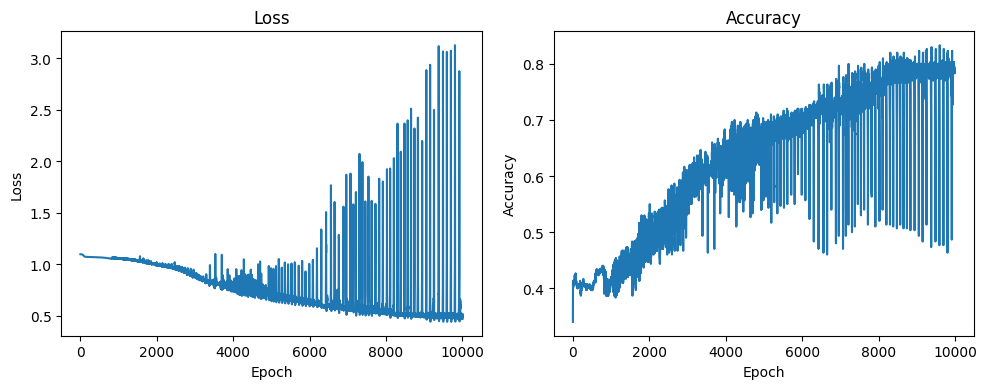

In [40]:
#full pipeline with vanilla optimizer

import matplotlib.pyplot as plt

losses = []
accuracies = []

dense1 = DenseLayer(2,64)
activation1 = Activation_ReLU()

dense2 = DenseLayer(64,3)

loss_activation = ACtivation_softmax_Loss_CategoricalCrossentropy()
optimizer = VanillaOptimizer(learning_rate=1)

#training loop 
for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.out)  # forward pass through activation

    dense2.forward_pass(activation1.output)  # forward pass through second dense layer
    loss = loss_activation.forward(dense2.out, y_true_matrix)  # forward pass through combined

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)

    accuracy = np.mean(predictions == y)

    losses.append(loss)
    accuracies.append(accuracy)


    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'loss: {loss:.3f}, ' +
              f'accuracy: {accuracy:.3f}')
        
    #backward pass
    loss_activation.backward(loss_activation.output,y)  #derivation of loss with respect to output
    dense2.backward_pass(loss_activation.dinputs) #derivation of loss with respect to weights and biases of dense2 layer
    activation1.backward(dense2.dinputs) #derivation of loss with respect to output of dense1 layer passing relu derivative
    dense1.backward_pass(activation1.dinputs) #derivation of loss with respect to weights and biases of dense1 layer


    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

epoch: 0, loss: 1.099, accuracy: 0.270 learning rate: 1.0
epoch: 100, loss: 1.083, accuracy: 0.417 learning rate: 0.9099181073703367
epoch: 200, loss: 1.073, accuracy: 0.407 learning rate: 0.8340283569641367
epoch: 300, loss: 1.072, accuracy: 0.410 learning rate: 0.7698229407236336
epoch: 400, loss: 1.071, accuracy: 0.410 learning rate: 0.7147962830593281
epoch: 500, loss: 1.071, accuracy: 0.410 learning rate: 0.66711140760507
epoch: 600, loss: 1.070, accuracy: 0.410 learning rate: 0.6253908692933083
epoch: 700, loss: 1.069, accuracy: 0.417 learning rate: 0.5885815185403178
epoch: 800, loss: 1.068, accuracy: 0.430 learning rate: 0.5558643690939411
epoch: 900, loss: 1.067, accuracy: 0.430 learning rate: 0.526592943654555
epoch: 1000, loss: 1.065, accuracy: 0.433 learning rate: 0.5002501250625312
epoch: 1100, loss: 1.063, accuracy: 0.433 learning rate: 0.4764173415912339
epoch: 1200, loss: 1.061, accuracy: 0.430 learning rate: 0.45475216007276037
epoch: 1300, loss: 1.057, accuracy: 0.427

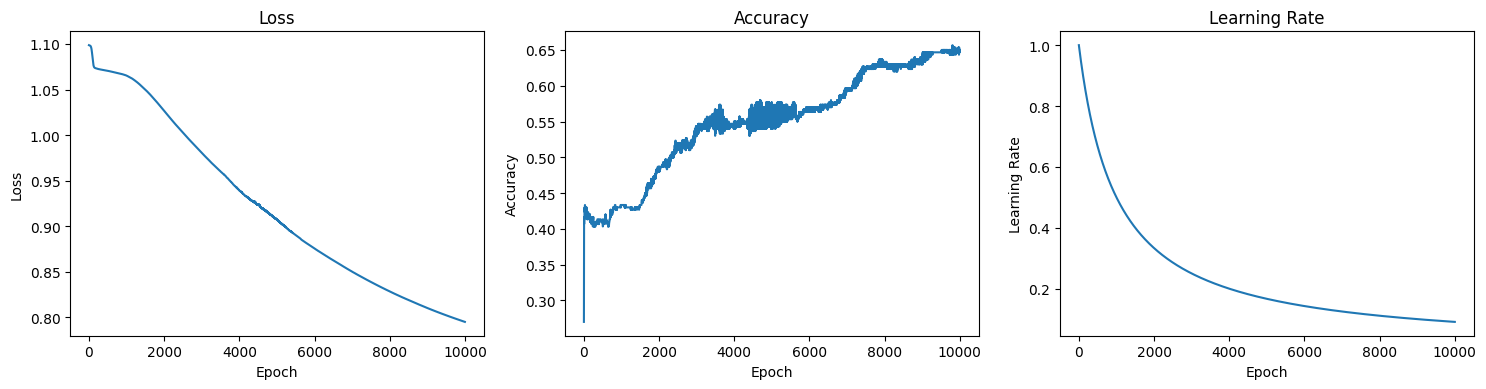

: 

In [ ]:
#full pipeline with learning rate decay optimizer

import matplotlib.pyplot as plt

losses = []
accuracies = []
learning_rates = []

dense1 = DenseLayer(2,64)
activation1 = Activation_ReLU()

dense2 = DenseLayer(64,3)

loss_activation = ACtivation_softmax_Loss_CategoricalCrossentropy()
optimizer = LearningRateDecayOptimizer(decay=1e-3)

#training loop 
for epoch in range(10001):
    dense1.forward_pass(X)
    activation1.forward(dense1.out)  # forward pass through activation

    dense2.forward_pass(activation1.output)  # forward pass through second dense layer
    loss = loss_activation.forward(dense2.out, y_true_matrix)  # forward pass through combined

    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)

    accuracy = np.mean(predictions == y)

    losses.append(loss)
    accuracies.append(accuracy)


    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'loss: {loss:.3f}, ' +
              f'accuracy: {accuracy:.3f}', 
              f'learning rate: {optimizer.current_learning_rate}')
        
    #backward pass
    loss_activation.backward(loss_activation.output,y)  #derivation of loss with respect to output
    dense2.backward_pass(loss_activation.dinputs) #derivation of loss with respect to weights and biases of dense2 layer
    activation1.backward(dense2.dinputs) #derivation of loss with respect to output of dense1 layer passing relu derivative
    dense1.backward_pass(activation1.dinputs) #derivation of loss with respect to weights and biases of dense1 layer

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    learning_rates.append(optimizer.current_learning_rate)

# Plot
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,3,2)
plt.plot(accuracies)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1,3,3)
plt.plot(learning_rates)
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()